# Reconstruction of the directional wave spectrum using IOWAGA 


In [103]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import netCDF4 as nc
import os
%matplotlib inline

## Jonswap spectrum and directional distribution

$$
\begin{aligned}
  S(f)     &= \frac{\alpha g^2}{(2\pi)^4 f^5}
              \exp \left( -\beta \left(\frac{f_p}{f}\right)^4 \right)
              \gamma^{\delta} \\
  \delta   &= \exp\left( -\frac{(f-f_p)^2}{2(\sigma_0 f_p)^2} \right) \\
  \sigma_0 &= \left\{
    \begin{array}{lr}
      0.07 & : f <   f_p \\
      0.09 & : f \ge f_p
    \end{array}
  \right.
\end{aligned}
$$



$$
\begin{aligned}
D(f,\theta) &= 0.5 \beta \mathrm{sech}^2 \beta (\theta - \theta_m(f)) \\
\beta &= \left\{
  \begin{array}{lcr}
    2.61 (f/f_p)^{1.3}  & : & 0.56 < f/f_p < 0.95 \\
    2.28 (f/f_p)^{-1.3} & : & 0.95 < f/f_p < 1.16 \\
    10^p             & : & f/f_p > 1.60
  \end{array}
\right. \\
p &= -0.4 + 0.8393 \cdot e^{-0.567 \ln (f/f_p)^2}
\end{aligned}
$$



In [3]:
# jonswap spectrum
def jonswap(frqs, Hs, Tp, gamma=3.3):
    """Returns the JONSWAP spectrum for a given Hs, Tp and frequency array"""
    
    # constants
    fp = 1./Tp
    alpha, beta, g = 8.1E-3, 5./4., 9.8
    
    # it could be vectorized!
    S = np.zeros_like(frqs)
    for i, f in enumerate(frqs):
        if f == 0.:
            S[i] = 0.
        else:
            num = alpha * (g**2)
            den = ((2*np.pi)**4) * f**5
            pm = (num / den) * np.exp(-beta * (fp/f)**4)
            sigma = 0.07 if f <= fp else 0.09
            r = np.exp(-(f - fp)**2 / (2.*(sigma**2)*(fp**2)))
            S[i] = pm * gamma**r
    
    # scale spectrum with zero-order moment 
    m0 = np.trapz(S, x=frqs)
    return (S / m0) * (Hs**2 /16)

In [4]:
# directional wave spectrum 
def directional_wave_spectrum(frqs, dirs, Hs, Tp, mdir, func="cos2s", s=1):
    """Returns the directional wave spectrum"""
     
    # frequency spectrum from jonswap
    S = jonswap(frqs, Hs=Hs, Tp=Tp, gamma=3.3)

    # direction arrays
    dir2 = (dirs - mdir) % 360
    dir3 = dirs - 180

    # cos2s
    if func == "cos2s":
        #
        D = (2. / np.pi) * np.cos((dirs - mdir)*np.pi/180.)**(2*s)
        D[np.logical_and(dir2>90, dir2<270)] = 0.
        E = S[None,:] * D[:,None]
        
    # sech2
    if func == "sech2":
        #
        ffp = frqs*Tp
        beta = np.ones(len(frqs))*1.24
        beta[np.logical_and(ffp>=0.56, ffp<0.95)] = 2.61 * ffp[np.logical_and(ffp>=0.56, ffp<0.95)]**(1.3)
        beta[np.logical_and(ffp>=0.95, ffp<1.60)] = 2.28 * ffp[np.logical_and(ffp>=0.95, ffp<1.60)]**(-1.3)
        E = S[None,:] * (beta[None,:] / 2) * np.cosh(beta[None,:] * (dir3[:,None])*np.pi/180.)**(-2)
        #
        ixd = np.argsort(((dir3 + mdir) % 360))
        E = E[ixd,:]
    
    # scale spectrum with zero-order moment 
    m0 = np.abs(np.trapz(np.trapz(E, x=np.radians(dirs), axis=0), x=frqs))
    return (E / m0) * (Hs**2 / 16)

## Nice representation of the spectrum

In [148]:
# plot wave spectrum
def plot_wave_spectrum(frqs, dirs, E, ax=None, label_angle=-45):
    """Polar representation of a directional wave spectrum"""

    if dirs[-1] != 360.:
        E_copy = E.copy()
        dirs = np.append(dirs, 360)
        E = np.zeros((len(dirs), len(frqs)))
        E[:-1,:] = E_copy
        E[-1,:] = E_copy[0,:]
        
    Fx = frqs[None,:] * np.cos(dirs[:,None]*np.pi/180)
    Fy = frqs[None,:] * np.sin(dirs[:,None]*np.pi/180)
    
    if not ax:
        fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=120)
    
    colors = ["#FFFFFF", "#01DFA5", "#FE642E", "#08298A", "#01A9DB"]
    cmap = mcolors.LinearSegmentedColormap.from_list('cmap', colors, N=1024)
    
    smin, smax= -1., 2.
    norm = mcolors.LogNorm(vmin=10**smin, vmax=10**smax)
    
    pc = ax.pcolormesh(Fx, Fy, E, cmap=cmap, norm=norm)
    cf = ax.contour(Fx, Fy, E, np.array([0.25, 0.5, 0.75, 1.0])*E.max(), colors="k")
    
    ax.text(0.50, 0.95, "N", transform=ax.transAxes, ha="center", va="center")
    ax.text(0.95, 0.50, "E", transform=ax.transAxes, ha="center", va="center")
    ax.text(0.50, 0.05, "S", transform=ax.transAxes, ha="center", va="center")
    ax.text(0.05, 0.50, "W", transform=ax.transAxes, ha="center", va="center")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_ylabel("$f \, \mathrm{ [Hz]}$")
    
    fmax, fstep = 0.5, 0.1
    ax.set_xlim((-0.4, 0.4))
    ax.set_ylim((-0.4, 0.4))
    
    ticks = np.append(np.arange(-fmax, 0, fstep), np.arange(0, fmax+fstep, fstep)[1:])
    for radii in ticks[ticks > 0]:
        circle = plt.Circle((0,0), radii, color="0.5", linestyle="dashed", fill=False)
        ax.add_artist(circle)
        ax.text(radii*np.cos(np.radians(label_angle)), 
                radii*np.sin(np.radians(label_angle)),
                f"{radii:.1f}")

Text(0.5,1,'sech2')

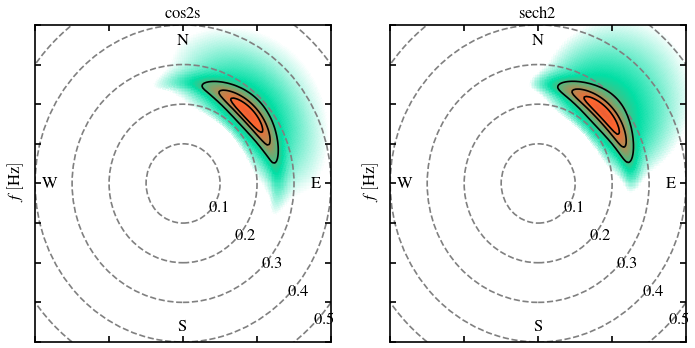

In [151]:
frqs = np.linspace(0,1,256)
dirs = np.arange(360)
E_cos2s = directional_wave_spectrum(frqs, dirs, Hs=2, Tp=4, mdir=45, func="sech2")
E_sech2 = directional_wave_spectrum(frqs, dirs, Hs=2, Tp=4, mdir=45, func="cos2s", s=4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3.5), dpi=120)
plot_wave_spectrum(frqs, dirs, E_cos2s, ax=ax1)
plot_wave_spectrum(frqs, dirs, E_sech2, ax=ax2)
ax1.set_title("cos2s")
ax2.set_title("sech2")

## Retrieving the data from the web

In [94]:
# download file from ifremer ftp server
def download_from_ftp(filename):
    """Copy file from FTP to local directory"""

    local_path = "/Volumes/Boyas/iowaga/"
    
    with ftplib.FTP("ftp.ifremer.fr") as ftp:
        
        # login the ftp
        ftp.login()
        ftp.cwd("ifremer/ww3/HINDCAST/")

        # create local folder if it does not exist
        folder = os.path.join(local_path, os.path.split(filename)[0])
        if not os.path.exists(folder):
            os.makedirs(folder)
        
        print(f"Downloading from FTP: {filename}")
        with open(os.path.join(local_path, filename), "wb") as f:
            cmd = f"RETR {filename}"
            try:
                ftp.retrbinary(cmd, f.write)
                return True
            except:
                print("File couldn't be downloaded")
                return False


In [95]:
# load dataset
def load_dataset(year, month, region="GLOBAL", wind_source="ECMWF"):
    """Returns all the netcdf datasets por the specific region"""

    local_path = "/Volumes/Boyas/iowaga/"
    basename = f"{region}/{year}_{wind_source}/partitions"

    if region == "GLOBAL":
        grid = "30M"
        rcode = "GLOB"
    else:
        grid = "10M"

    dic = {}
    list_of_variables = ["phs", "pdir", "ptp"]
    for variable in list_of_variables:
        for partition in range(6):
            
            # create filename
            parameter = f"{variable}{partition}"
            filename = f"{basename}/WW3-{rcode}-{grid}_{year}{month:02d}_{parameter}.nc"
            
            # check if local filename exist
            local_filename = os.path.join(local_path, filename)
            if os.path.exists(local_filename):
                dataset = nc.Dataset(local_filename, "r")
            #
            # if not, download it from ftp server
            else:
                result = download_from_ftp(filename)
                if result:
                    dataset = nc.Dataset(local_filename, "r")

            # store in a dictionary
            dic[parameter] = dataset

    return dic

In [96]:
# extract data in a specific point
def extract_point(dic, date, lon=-96.6245, lat=24.6028):
    """Extract the partition parameters in a specific point"""

    results = {}
    for parameter, dataset in dic.items():
        
        # choose the interest variables
        time = nc.num2date(dataset["time"][:].data, dataset["time"].units)
        glat = dataset["latitude"][:]
        glon = dataset["longitude"][:]
        
        # find the indices of the specific point
        ixtime = np.argmin(abs(time - date))
        ixlat = np.argmin(abs(glat - lat))
        ixlon = np.argmin(abs(glon - lon))

        # load the variables in a point
        value = np.float32(dataset[parameter][ixtime, ixlat, ixlon])
        results[parameter] = value

    # save lon, lat and time
    results["lon"] = glon[ixlon]
    results["lat"] = glat[ixlat]
    results["time"] = time[ixtime]

    return results

In [108]:
# construct spectrum
def construct_spectrum(results):
    """Return spectrum for the parameters passed in results"""

    # create spectrum using a sech function
    frqs = np.arange(0.01, 1, 0.01)
    dirs = np.arange(360)
    E = np.zeros((len(dirs), len(frqs)))
    #
    for partition in range(6):
        Hs = results[f"phs{partition}"]
        Tp = results[f"ptp{partition}"]
        pdir = (270-results[f"pdir{partition}"]) % 360
        #
        if Hs != 0:
            E += directional_wave_spectrum(frqs, dirs, Hs, Tp, pdir, func="sech2")

    return frqs, dirs, E

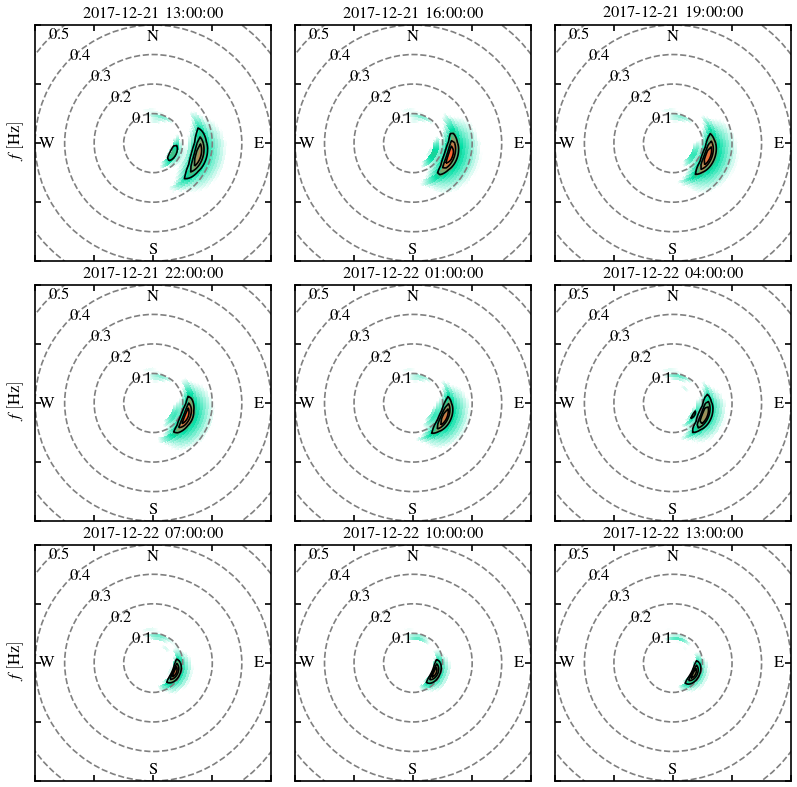

In [150]:
# define date and location
date = dt.datetime(2017, 12, 21, 13, 0)
lon, lat =-116.83, 31.82

# create canvas
fig, ax = plt.subplots(3, 3, figsize=(7,7), dpi=120)
fig.subplots_adjust(top=.95, bottom=.05, left=.05, right=.95, wspace=.1, hspace=.1)
ax = np.ravel(ax)

# loop for each panel (nine in total)
for i in range(9):
    #
    results = extract_point(dic, date, lon=lon, lat=lat)
    frqs, dirs, E = construct_spectrum(results)
    #
    if i in [2,5,8]:
        plot_wave_spectrum(frqs, dirs, E, ax=ax[i], label_angle=135)
    else:
        plot_wave_spectrum(frqs, dirs, E, ax=ax[i], label_angle=135)

    # set title
    title = date.strftime("%Y-%m-%d %H:%M:%S")
    ax[i].set_title(title)

    # tune up axes
    if i not in [6,7,8]:
        ax[i].set_xlabel("")
        ax[i].set_xticklabels([''])
    #
    if i not in [0,3,6]:
        ax[i].set_ylabel("")
        ax[i].set_yticklabels([''])

    # next spectrum
    date += dt.timedelta(hours=3)